In [ ]:
import cv2
from collections import OrderedDict
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
!wget https://img2.freepng.fr/20240227/kis/transparent-cartoon-aliens-alien-figures-green-alien-blue-alie-three-alien-figures-with-crossed-arms65dd7f93c91b79.7205194517090149318237.jpg

--2024-02-27 12:21:15--  https://img2.freepng.fr/20240227/kis/transparent-cartoon-aliens-alien-figures-green-alien-blue-alie-three-alien-figures-with-crossed-arms65dd7f93c91b79.7205194517090149318237.jpg
Resolving img2.freepng.fr (img2.freepng.fr)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3121::, ...
Connecting to img2.freepng.fr (img2.freepng.fr)|188.114.97.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125085 (122K) [image/jpeg]
Saving to: ‘transparent-cartoon-aliens-alien-figures-green-alien-blue-alie-three-alien-figures-with-crossed-arms65dd7f93c91b79.7205194517090149318237.jpg.1’

transparent-cartoon 100%[===================>] 122.15K  --.-KB/s    in 0.005s  

2024-02-27 12:21:15 (24.2 MB/s) - ‘transparent-cartoon-aliens-alien-figures-green-alien-blue-alie-three-alien-figures-with-crossed-arms65dd7f93c91b79.7205194517090149318237.jpg.1’ saved [125085/125085]



h: 1548 w: 3676 hxw: 5690448


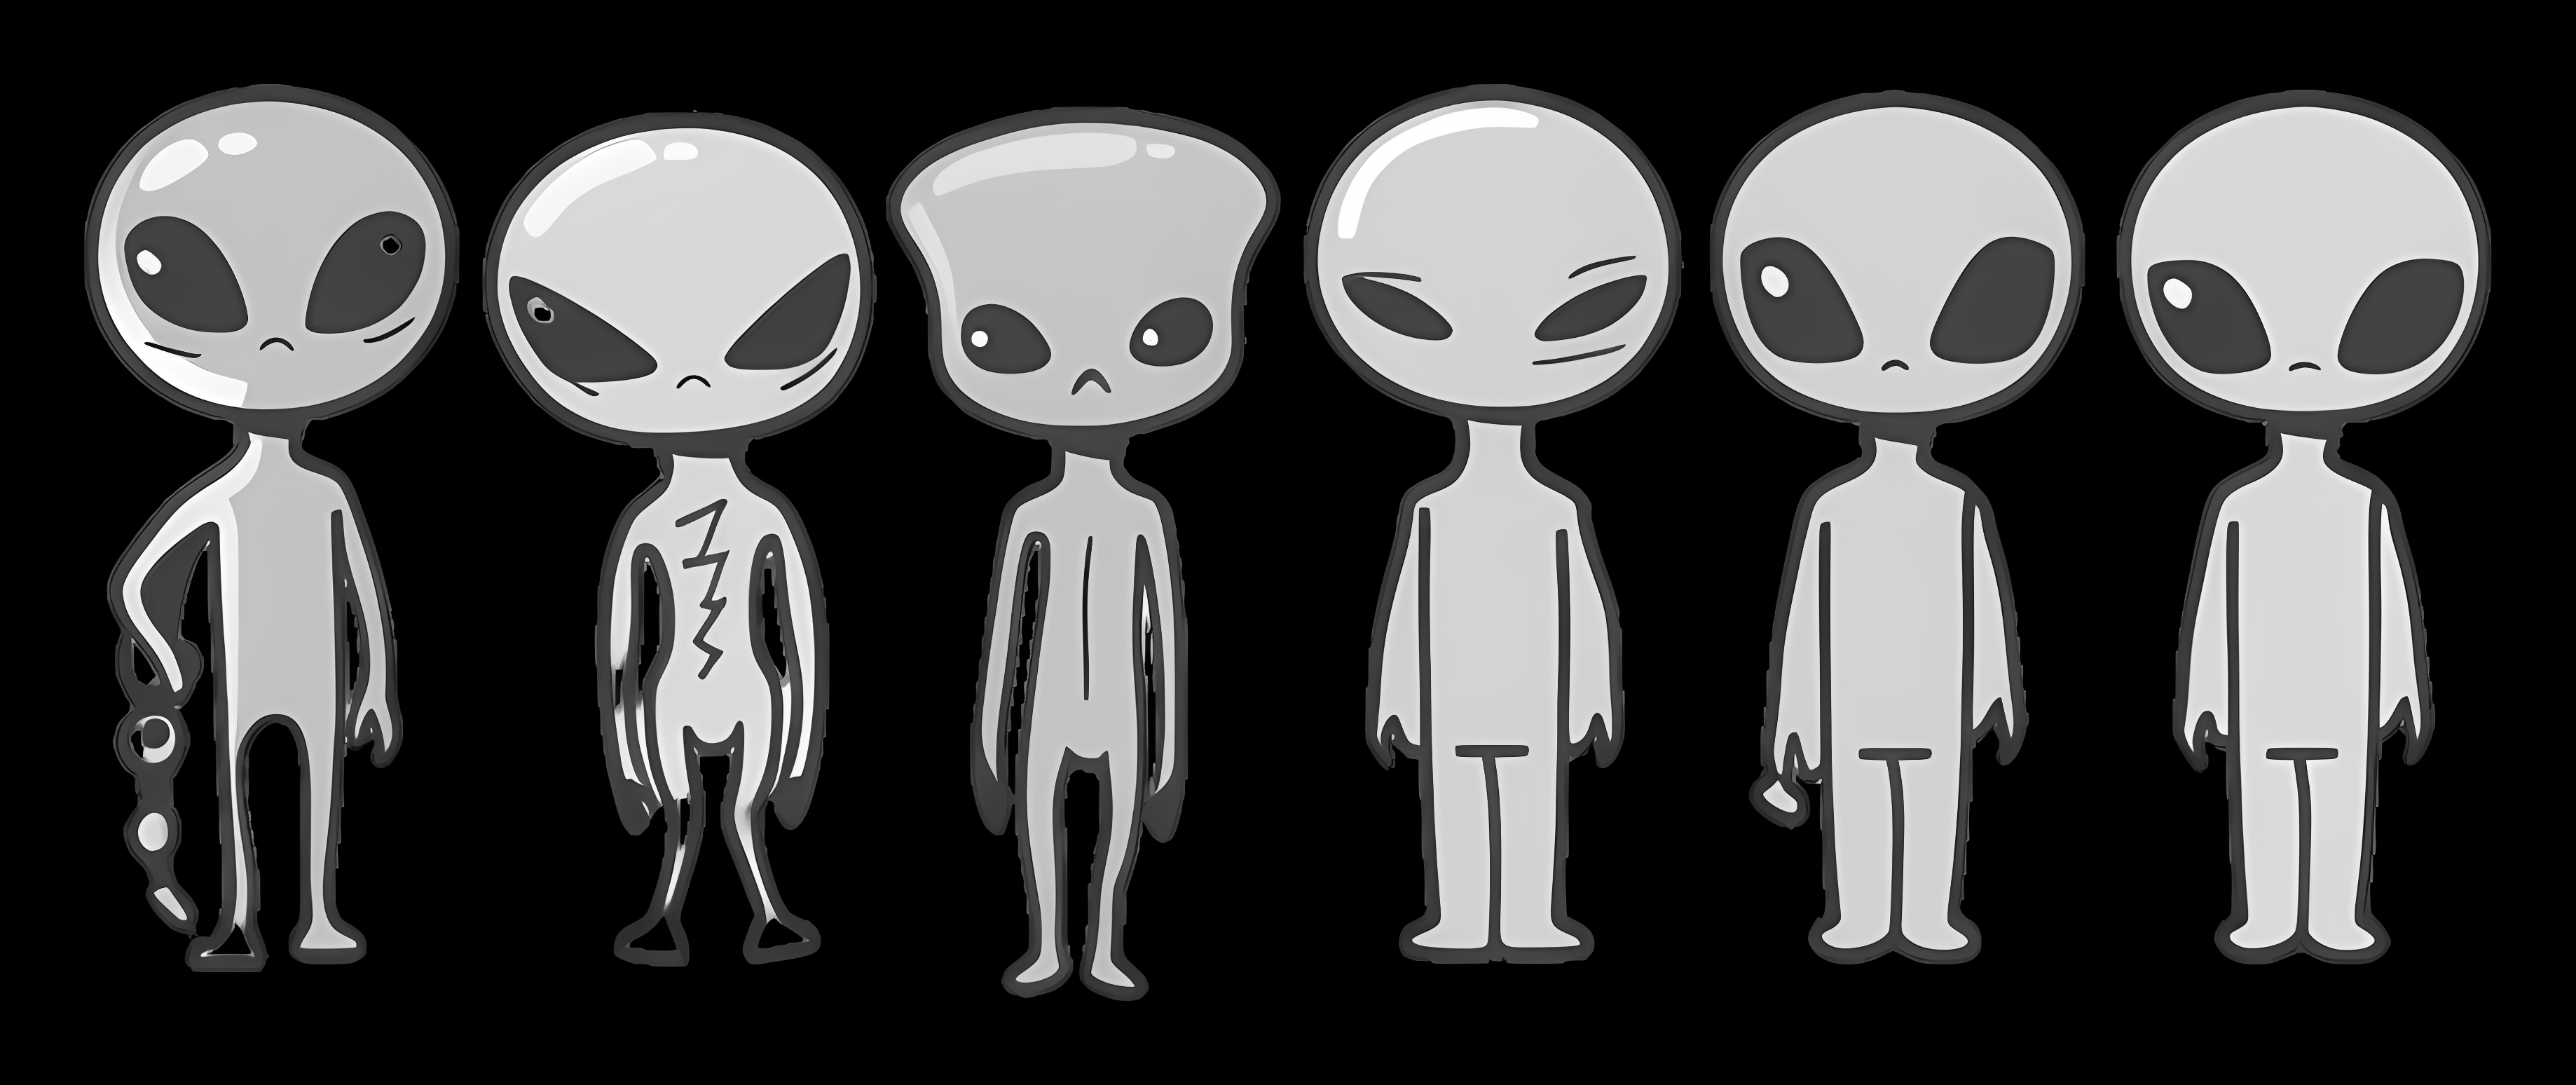

In [ ]:
# input image
img = Image.open("aliens.png")
w, h = img.size
img_np = np.asarray(img)
img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
n = w * h
print(f'h: {h} w: {w} hxw: {n}')
Image.fromarray(img_np)

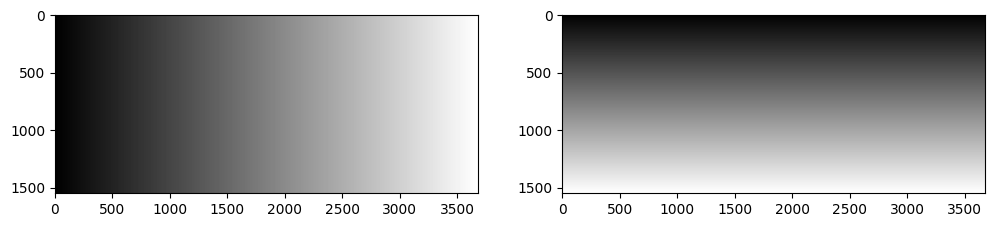

In [ ]:
# Input data
u = np.arange(w) / w
v = np.arange(h) / h
uu, vv = np.meshgrid(u, v)
uv = np.stack((uu, vv), axis=2)
uvr = uv.reshape((n, 2))
cr = img_np.reshape((n, 1)) / 255.0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(uu, cmap='gray')
ax[1].imshow(vv, cmap='gray')

In [ ]:
class SkipLinear(nn.Module):
    def __init__(self, num_hidden):  # Corrected from _init_ to __init__
        super().__init__()
        self.num_hidden = num_hidden
        self.linear = nn.Linear(num_hidden, num_hidden, bias=True)

    def forward(self, x):
        assert x.size(1) == self.num_hidden
        y = self.linear(x)
        return F.relu(x + y)

In [ ]:
class NaiveNet(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, num_hidden: int, num_layers: int):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.backbone = OrderedDict()
        self.backbone['input_linear'] = nn.Linear(input_dim, num_hidden, bias=True)
        self.backbone['input_act'] = nn.ReLU()

        for i in range(num_layers):
            self.backbone[f"layer_{i}"] = SkipLinear(num_hidden)

        self.backbone = nn.Sequential(self.backbone)
        self.head = nn.Linear(num_hidden, output_dim, bias=True)

    def forward(self, x):
        h = self.backbone(x)
        h = self.head(h)
        y = torch.sigmoid(h)
        return y

In [ ]:
net = NaiveNet(input_dim=2, output_dim=1, num_hidden=96, num_layers=2)
net.cuda()

npar = 0
for p in net.parameters():
    print(p.size(), p.numel())
    npar += p.numel()

print(npar)

torch.Size([96, 2]) 192
torch.Size([96]) 96
torch.Size([96, 96]) 9216
torch.Size([96]) 96
torch.Size([96, 96]) 9216
torch.Size([96]) 96
torch.Size([1, 96]) 96
torch.Size([1]) 1
19009


In [ ]:
tx = torch.tensor(uvr, dtype=torch.float32).cuda()
ty = torch.tensor(cr, dtype=torch.float32).cuda()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
num_global_epoch=10000

progress = tqdm(range(num_global_epoch))
avg_loss = 1
beta = 0.05
loss_records = list()
net.train()
for i in progress:

    p = net (tx)
    loss = 10 * criterion(p, ty)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss = (1-beta) * avg_loss + beta * loss.item()
    loss_records.append(loss.item())
    progress.set_description(
            f"Epoch {i} | Loss {avg_loss:.8f}"
        )

Epoch 999 | Loss 0.25650380: 100%|██████████| 1000/1000 [09:51<00:00,  1.69it/s]


In [ ]:
plt. plot(range(num_global_epoch), loss_records)

In [ ]:
net.eval()

with torch.no_grad():
    p = net(tx)



pimg = (255 * p.cpu().numpy()).astype('uint8')
pimg = pimg.reshape((h, w))

disp = np.concatenate([img_np, pimg], axis=1)
Image.fromarray(disp)